![download.png](download.png)


## Import Packages

In [ ]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window


## Connect to Snowflake

In [ ]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "tasty_data_scientist",
    "warehouse": "tasty_ds_wh",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [ ]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")
#
frostbyte_safegraph=session.table("frostbyte_safegraph.public.frostbyte_tb_safegraph_s")


## Preview The Data

In [ ]:
#tasty_bytes_orders_v.group_by(F.to_date(F.col('ORDER_TS'))).count().to_pandas().to_csv('C:\\Users\\ryanl\\Downloads\\analysis_4.csv')

In [ ]:
tasty_bytes_orders_v.filter(F.col('CUSTOMER_ID').isNull()).group_by(F.to_date(F.col('ORDER_TS'))).count().to_pandas().to_csv('C:\\Users\\ryanl\\Downloads\\non-member-trans.csv')

In [ ]:
customer_loyalty_orders=tasty_bytes_customer_loyalty.join(
    right=tasty_bytes_orders_v,
    on="CUSTOMER_ID",
    how="inner"
)

In [ ]:
print("Number of rows:", customer_loyalty_orders.count())
customer_loyalty_orders.show()

# RFM Analysis

In [ ]:
temp=['CUSTOMER_ID', 'ORDER_ID', 'ORDER_TS', 'ORDER_TOTAL']
RFM_data=customer_loyalty_orders[temp]

last_recorded_date=customer_loyalty_orders.select(F.max(F.to_date(F.col('ORDER_TS'))).alias('max_date'))
#Convert ORDERDATE to datetime format.
RFM_data= RFM_data.withColumn('ORDER_TS', F.to_date(F.col('ORDER_TS')))


In [ ]:
last_recorded_date.show()

In [ ]:
#Recency
recency=RFM_data.group_by('CUSTOMER_ID').max('ORDER_TS').to_pandas()
recency['RECENCY']=(dt.datetime(2022,11,1)-pd.to_datetime(recency['MAX(ORDER_TS)'])).dt.days

In [ ]:
#Frequency
frequency=RFM_data.group_by('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency')).to_pandas()


In [ ]:
#Monetary
monetary=RFM_data.group_by('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary')).to_pandas()

In [ ]:
RFM_table=recency.merge(right=frequency, how="inner",on='CUSTOMER_ID')
RFM_table=RFM_table.merge(right=monetary,how='inner',on='CUSTOMER_ID')
RFM_table.drop(labels='MAX(ORDER_TS)',inplace=True,errors='ignore')

In [ ]:
quantiles_1 = RFM_table[['RECENCY','FREQUENCY','MONETARY']].quantile(q=[0.2,0.4,0.6,0.8])
quantiles_1

In [ ]:
# Converting quantiles to a dictionary, easier to use.
quantiles = quantiles_1.to_dict()
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x<=d[p][0.8]:
        return 2 
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x<=d[p][0.8]:
        return 4 
    else:
        return 5
RFM_Segment['R_Quartile'] = RFM_Segment['RECENCY'].apply(R_Class, args=('RECENCY',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['FREQUENCY'].apply(FM_Class, args=('FREQUENCY',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['MONETARY'].apply(FM_Class, args=('MONETARY',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [ ]:
#RFM_Segment.to_csv('C:\\Users\\ryanl\\Downloads\\RFMAnalysis.csv')
RFM_Segment.head()

In [ ]:
sns.histplot(RFM_Segment['RECENCY'])
plt.title("Histogram of Member's Recency")

In [ ]:
sns.histplot(RFM_Segment['FREQUENCY'])
plt.title("Histogram of Member's Frequency")

In [ ]:
sns.histplot(RFM_Segment['MONETARY'])
plt.title("Histogram of Member's Monetary Value")

In [ ]:
RFM_Segment['Segment']=np.nan
best=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="555"].index)
lost_cheap=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="111"].index)
lost=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="155"].index)
lost_almost=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="455"].index)
for i in RFM_Segment.index:
    if i in lost_cheap:
        RFM_Segment['Segment'].iloc[i]='Lost Cheap Customers'
    elif i in lost:
        RFM_Segment['Segment'].iloc[i]='Lost Customers'
    elif i in best:
        RFM_Segment['Segment'].iloc[i]='Best Customers'
    elif i in lost_almost:
        RFM_Segment['Segment'].iloc[i]='Almost Lost'
    else:
        RFM_Segment['Segment'].iloc[i]='Others'

In [136]:

loyal=list(RFM_Segment.loc[RFM_Segment['F_Quartile']==5].index)
loyal2=[]
for i in loyal:
    if i not in best and i not in lost_cheap and i not in lost_almost and i not in lost:
        loyal2.append(i)
for i in RFM_Segment.index:
    if i in loyal2:
        RFM_Segment['Segment'].iloc[i]='Loyal Customers'

C:\Users\ryanl\AppData\Local\Temp\ipykernel_24772\3661097642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Segment['Segment'].iloc[i]='Loyal Customers'


In [137]:

big=list(RFM_Segment.loc[RFM_Segment['M_Quartile']==5].index)
big2=[]
for i in big:
    if i not in best and i not in lost_cheap and i not in lost_almost and i not in lost:
        big2.append(i)
for i in RFM_Segment.index:
    if i in big2:
        RFM_Segment['Segment'].iloc[i]='Big Spenders'

C:\Users\ryanl\AppData\Local\Temp\ipykernel_24772\1932073774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Segment['Segment'].iloc[i]='Big Spenders'


Text(0.5, 1.0, 'Customers per Segment')

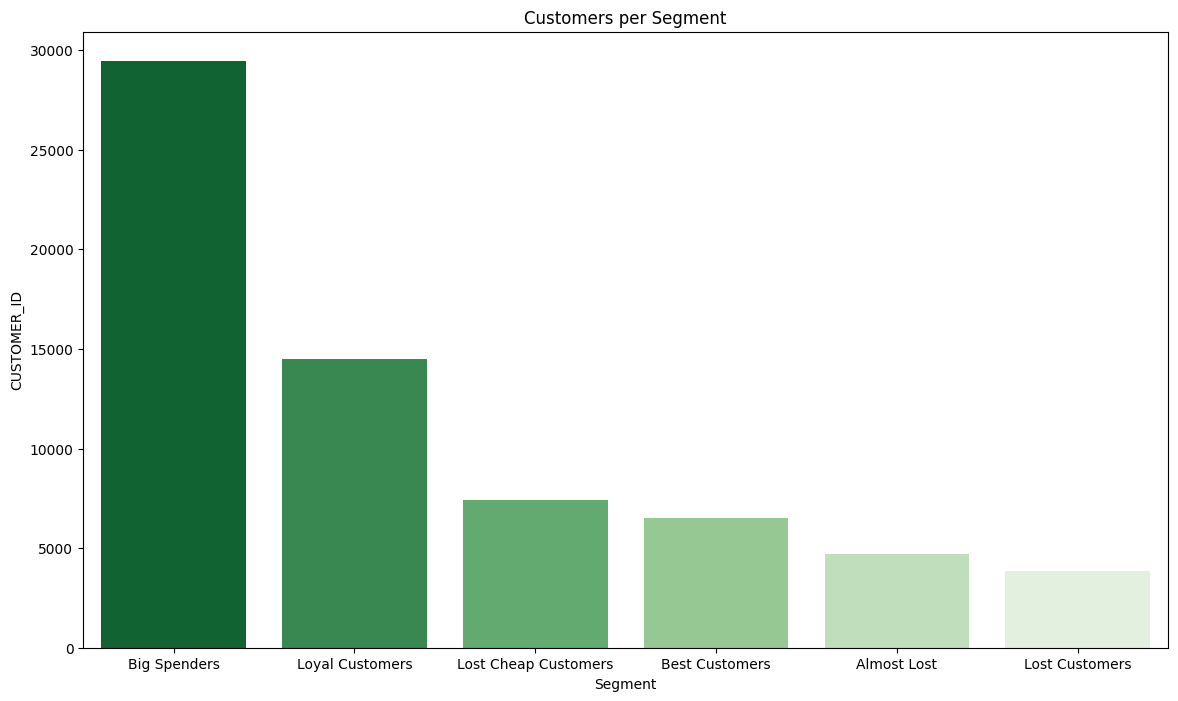

In [143]:
query=RFM_Segment.groupby('Segment')['CUSTOMER_ID'].nunique().sort_values(ascending=False).reset_index()
query.drop([0],inplace=True)
plt.figure(figsize=(14,8))
sns.barplot(data=query,x='Segment',y='CUSTOMER_ID',palette='Greens_r')
plt.title('Customers per Segment')

# Churn Period of 2 weeks


In [ ]:
last_order=customer_loyalty_orders.group_by('CUSTOMER_ID').max(F.to_date(F.col('ORDER_TS')))
last_recorded_date=customer_loyalty_orders.select(F.max(F.to_date(F.col('ORDER_TS'))).alias('max_date'))
last_recorded_date.show()
last_order.show()


--------------
|"MAX_DATE"  |
--------------
|2022-11-01  |
--------------

--------------------------------------------
|"CUSTOMER_ID"  |"MAX(TO_DATE(ORDER_TS))"  |
--------------------------------------------
|110011         |2022-10-27                |
|92950          |2022-10-31                |
|39502          |2022-10-11                |
|197163         |2022-10-11                |
|50480          |2022-10-11                |
|76592          |2022-10-27                |
|8870           |2022-10-27                |
|15416          |2022-10-30                |
|108521         |2022-10-22                |
|176085         |2022-10-25                |
--------------------------------------------



In [ ]:
#Churn date
churn_date=last_recorded_date.select(F.dateadd("day", F.lit(-14),F.col('MAX_DATE')).alias('churn_date'))
churn_date.show()

----------------
|"CHURN_DATE"  |
----------------
|2022-10-18    |
----------------



In [ ]:
churn_df = last_order.withColumn('churned', 
    F.when(F.to_date(F.col('MAX(TO_DATE(ORDER_TS))')) < F.to_date(F.lit('2022-10-18')), 1)
    .otherwise(0)
)
churn_df.show()

--------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURNED"  |
--------------------------------------------------------
|7666           |2022-10-31                |0          |
|1407           |2022-10-31                |0          |
|16587          |2022-11-01                |0          |
|9153           |2022-10-13                |1          |
|9945           |2022-10-31                |0          |
|58             |2022-09-25                |1          |
|24472          |2022-10-31                |0          |
|29792          |2022-08-16                |1          |
|839            |2022-10-30                |0          |
|7163           |2022-10-29                |0          |
--------------------------------------------------------



Text(0.5, 1.0, 'Members who have not made any transactions in the last two week')

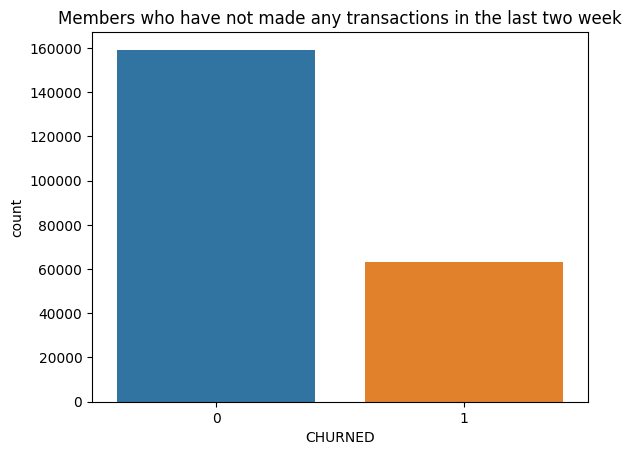

In [ ]:
temp_df=churn_df.to_pandas()
sns.countplot(data=temp_df,x='CHURNED')
plt.title('Members who have not made any transactions in the last two week')

# Top 20% High Spending Customers

In [12]:
total_order_by_customer = customer_loyalty_orders.group_by('CUSTOMER_ID').sum('ORDER_TOTAL').to_pandas()

# calculate the 80th percentile of order total
quantile_value = total_order_by_customer.quantile(q=0.80)

# filter the data to include only customers with order total greater than or equal to the 80th percentile value
top_20_customers = total_order_by_customer[total_order_by_customer['SUM(ORDER_TOTAL)'] >= quantile_value[1]]

# sort the top 20 customers by order total in descending order
top_20_customers = top_20_customers.sort_values(by='SUM(ORDER_TOTAL)',ascending=False)

# print the top 20 customers
print(top_20_customers.tail(20))

        CUSTOMER_ID  SUM(ORDER_TOTAL)
170267       149250          10473.50
76196         65359          10473.50
95310        181684          10473.50
146114        41614          10473.50
216964       204697          10473.50
151588       218711          10473.25
52613         47212          10473.25
108552       107793          10473.25
209325       173997          10473.25
31698        118966          10473.25
26892        144065          10473.25
55283         74130          10473.25
117780        14506          10473.25
197810       154771          10473.25
177414       118721          10473.00
134144         6125          10473.00
22352        142596          10473.00
15831        160579          10473.00
200754        30645          10473.00
173454        13042          10473.00


In [13]:
top_20_customers_list=top_20_customers['CUSTOMER_ID'].to_list()

#16,384, got 44,513

chunk_size = 10000
chunks = [top_20_customers_list[i:i+chunk_size] for i in range(0, len(top_20_customers_list), chunk_size)]


[[220394, 20728, 207698, 214336, 214282, 14586, 215840, 45123, 215894, 207999, 213836, 34020, 220653, 203102, 207603, 220703, 207836, 17380, 207535, 28673, 213865, 220582, 134417, 220517, 5922, 1394, 21522, 220672, 214441, 50965, 220184, 44187, 39126, 203349, 35157, 209563, 208149, 48643, 209426, 4552, 207595, 40734, 49079, 220332, 209988, 140181, 37591, 215603, 209757, 203939, 214283, 213789, 22686, 214342, 37374, 207553, 203337, 207729, 15697, 995, 214296, 203104, 13080, 203454, 203207, 4327, 215737, 14677, 20003, 209567, 10512, 213970, 207840, 30819, 209827, 34455, 207518, 215637, 31420, 28346, 222529, 222433, 2361, 48031, 210272, 23403, 222395, 24323, 49790, 203831, 220043, 222337, 220082, 203258, 216350, 8233, 210243, 214424, 12009, 209638, 216387, 210116, 5006, 5805, 87207, 203996, 213826, 62619, 2630, 36532, 207726, 30327, 38668, 214112, 222461, 26178, 222251, 11084, 209517, 210100, 10908, 220208, 209798, 214212, 215693, 213984, 37792, 42122, 216116, 222499, 216575, 35120, 21591

In [14]:
# Filter the dataframe based on the chunks and union the resulting dataframes
filtered_df = None
for chunk in chunks:
    chunk_df = customer_loyalty_orders.filter(F.col("CUSTOMER_ID").isin(chunk))
    if filtered_df:
        filtered_df = filtered_df.union(chunk_df)
    else:
        filtered_df = chunk_df

# Show the resulting dataframe
filtered_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"l_l0wg_FIRST_NAME"  |"l_l0wg_LAST_NAM

# Random

In [41]:
top20transac=filtered_df.group_by(F.to_date(F.col('ORDER_TS'))).count().to_pandas()
top20transac.to_csv('C:\\Users\\ryanl\\Downloads\\top20transac.csv')

In [15]:
top20avgspending=filtered_df.group_by(F.to_date(F.col('ORDER_TS'))).mean(F.col('ORDER_TOTAL')).to_pandas()
top20avgspending.to_csv('C:\\Users\\ryanl\\Downloads\\top20avgspending.csv')

In [ ]:
top20avgspending=filtered_df.group_by(F.to_date(F.col('ORDER_TS'))).sum(F.col('ORDER_TOTAL')).to_pandas()
top20avgspending.to_csv('C:\\Users\\ryanl\\Downloads\\top20spending.csv')

In [19]:
customer_loyalty_orders.group_by(F.to_date(F.col('ORDER_TS'))).sum("ORDER_TOTAL").to_pandas().to_csv('C:\\Users\\ryanl\\Downloads\\analysis_3.csv')

In [21]:
customer_loyalty_orders.group_by(F.to_date(F.col('ORDER_TS'))).sum("ORDER_TOTAL").to_pandas().head()

,TO_DATE(ORDER_TS),SUM(ORDER_TOTAL)
0,2022-02-23,2497018.00
1,2022-02-27,2343343.75
2,2022-03-07,2061197.25
3,2022-06-23,2461533.75
4,2022-06-30,2357999.25


In [26]:
customer_loyalty_orders.filter(F.year(F.col('SIGN_UP_DATE'))=='2019').show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"l_yseo_FIRST_NAME"  |"l_yseo_LAST_NAME"

<Axes: xlabel='TO_DATE(ORDER_TS)', ylabel='COUNT'>

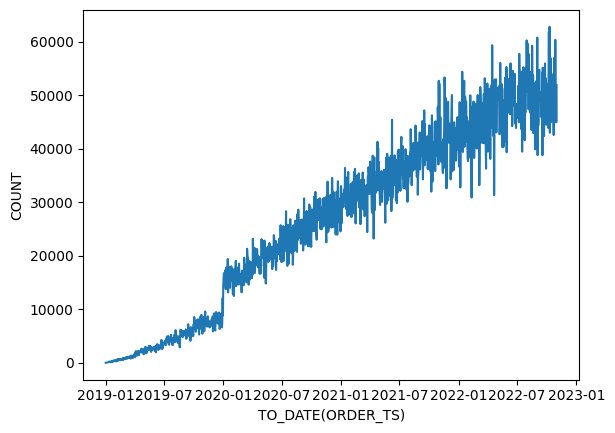

In [23]:
analysis_df=customer_loyalty_orders.group_by(F.to_date(F.col('ORDER_TS'))).count().to_pandas()
sns.lineplot(x='TO_DATE(ORDER_TS)',y='COUNT',data=analysis_df)

In [41]:
analysis_df.to_csv('C:\\Users\\ryanl\\Downloads\\analysis.csv')

<Axes: xlabel='TO_DATE(SIGN_UP_DATE)', ylabel='COUNT'>

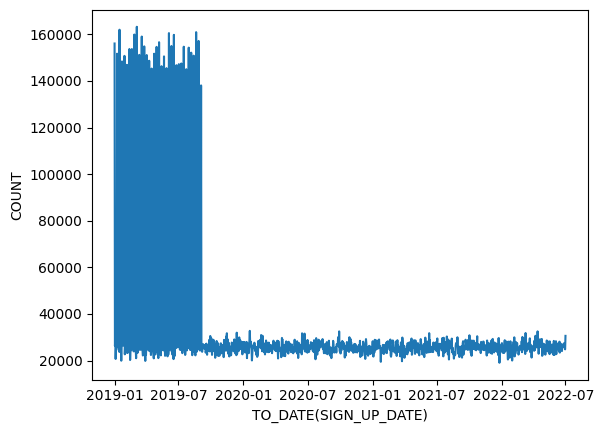

In [43]:
analysis_df_2=customer_loyalty_orders.group_by(F.to_date(F.col('SIGN_UP_DATE'))).count().to_pandas()
sns.lineplot(x='TO_DATE(SIGN_UP_DATE)',y='COUNT',data=analysis_df_2)

In [ ]:
analysis_df_2.to_csv('C:\\Users\\ryanl\\Downloads\\analysis_2.csv')